# Reducción de dimensionalidad en aprendizaje automático

En este notebook exploraremos distintas técnicas de reducción de dimensionalidad, tanto lineales como no lineales, usando ejemplos prácticos y visualizaciones.

**Objetivos:**

- Entender el rol de la reducción de dimensionalidad en problemas de machine learning.
- Aplicar métodos lineales como PCA y LDA, junto con variantes de PCA.
- Explorar métodos no lineales como Isomap, LLE, t-SNE y UMAP.
- Visualizar datos de alta dimensionalidad en 2D/3D, coloreando por etiquetas (`labels`).
- Discutir ventajas, limitaciones y criterios de elección de cada método.

Trabajaremos con distintos datasets de ejemplo (`iris`, `digits`, `swiss roll`, `circles`) para ilustrar diferentes comportamientos.


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris, load_digits, make_swiss_roll, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE

import umap

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["font.size"] = 11


- Funciones auxiliares

In [6]:
def plot_2d_embedding(X_embedded, labels=None, title=None, cmap="tab10"):
    """
    Visualiza un embedding 2D con colores según labels (si se proveen).
    """
    x1, x2 = X_embedded[:, 0], X_embedded[:, 1]
    plt.figure()
    scatter = plt.scatter(x1, x2, c=labels, cmap=cmap, s=20, alpha=0.8)
    if labels is not None:
        # Leyenda discreta para pocas clases
        unique_labels = np.unique(labels)
        handles, _ = scatter.legend_elements()
        plt.legend(handles, unique_labels, title="Label", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()


- Carga de datasets de ejemplo

In [7]:
# Iris (para PCA y LDA)
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
target_names_iris = iris.target_names

# Escalado típico para métodos lineales
scaler_iris = StandardScaler()
X_iris_scaled = scaler_iris.fit_transform(X_iris)

# Digits (para t-SNE y UMAP)
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

# Swiss roll (para métodos de manifold)
X_swiss, t_swiss = make_swiss_roll(n_samples=1000, noise=0.05, random_state=RANDOM_STATE)

# Circles (para KernelPCA)
X_circles, y_circles = make_circles(n_samples=500, factor=0.5, noise=0.05, random_state=RANDOM_STATE)


## 1. Reducción lineal: PCA (Análisis de Componentes Principales)

PCA busca una transformación lineal de los datos que:

- Maximize la varianza explicada en las primeras componentes.
- Encuentre direcciones ortogonales (componentes principales).
- Permita proyectar a baja dimensión (por ejemplo, 2D) conservando la mayor cantidad de información posible.

Aplicaremos PCA al dataset **Iris**, escalando primero las variables.


Varianza explicada por componente: [0.72962445 0.22850762]
Varianza acumulada: [0.72962445 0.95813207]


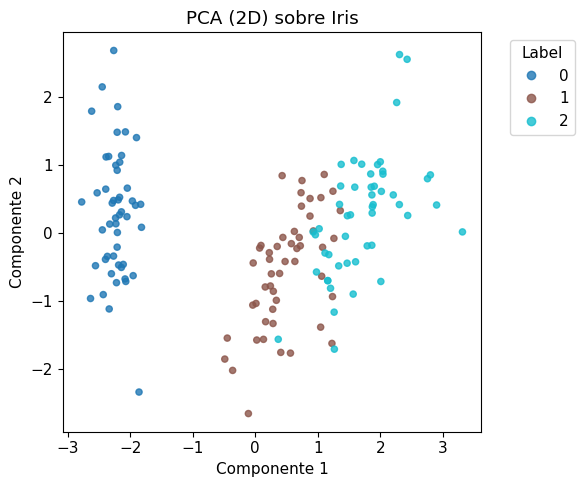

In [8]:
pca_iris = PCA(n_components=2, random_state=RANDOM_STATE)
X_iris_pca = pca_iris.fit_transform(X_iris_scaled)

print("Varianza explicada por componente:", pca_iris.explained_variance_ratio_)
print("Varianza acumulada:", np.cumsum(pca_iris.explained_variance_ratio_))

plot_2d_embedding(X_iris_pca, y_iris, title="PCA (2D) sobre Iris")


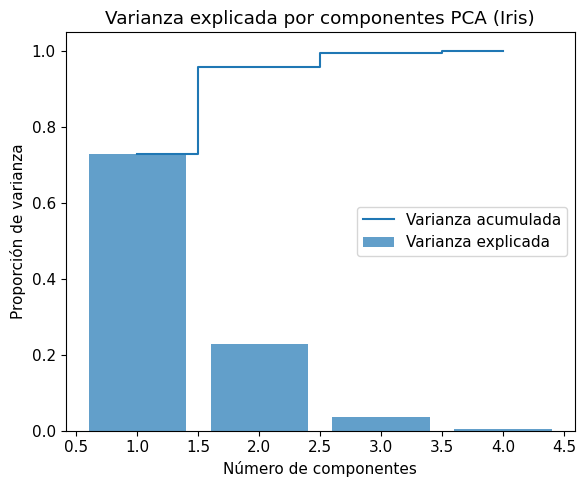

In [9]:
pca_full = PCA().fit(X_iris_scaled)
explained = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained)

plt.figure()
plt.bar(range(1, len(explained) + 1), explained, alpha=0.7, label="Varianza explicada")
plt.step(range(1, len(cum_explained) + 1), cum_explained, where="mid", label="Varianza acumulada")
plt.xlabel("Número de componentes")
plt.ylabel("Proporción de varianza")
plt.title("Varianza explicada por componentes PCA (Iris)")
plt.legend()
plt.tight_layout()
plt.show()


### 2.1 PCA con y sin escalado

El escalado puede cambiar drásticamente los resultados de PCA, ya que las variables con mayor varianza dominan las primeras componentes si no se normaliza.


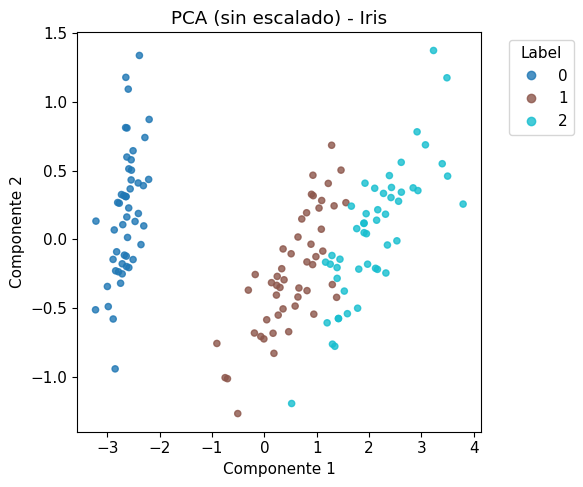

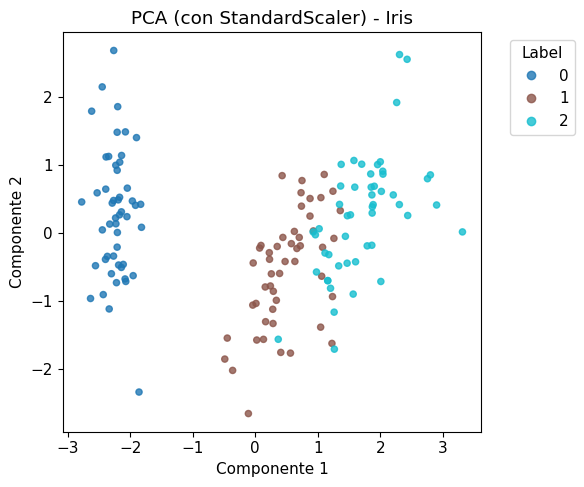

In [10]:
# Sin escalado
pca_no_scale = PCA(n_components=2, random_state=RANDOM_STATE)
X_iris_pca_no_scale = pca_no_scale.fit_transform(X_iris)

# Con escalado (ya lo teníamos)
pca_scale = PCA(n_components=2, random_state=RANDOM_STATE)
X_iris_pca_scale = pca_no_scale.fit_transform(X_iris_scaled)

plot_2d_embedding(X_iris_pca_no_scale, y_iris, title="PCA (sin escalado) - Iris")
plot_2d_embedding(X_iris_pca_scale, y_iris, title="PCA (con StandardScaler) - Iris")


### 2.2 IncrementalPCA

`IncrementalPCA` implementa un PCA aproximado que se entrena por lotes (batches), útil para datasets que no caben en memoria.
Aquí lo usamos solo para mostrar que se usa de forma similar.


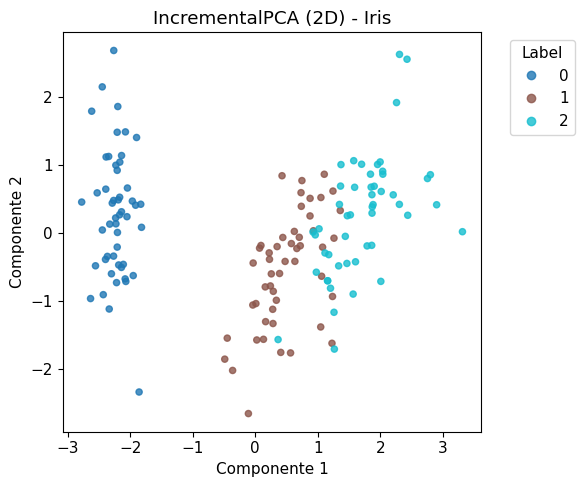

In [11]:
ipca = IncrementalPCA(n_components=2)
ipca.fit(X_iris_scaled)  # Aquí usamos todo de una vez, pero podría ser por batches

X_iris_ipca = ipca.transform(X_iris_scaled)
plot_2d_embedding(X_iris_ipca, y_iris, title="IncrementalPCA (2D) - Iris")


### 2.3 KernelPCA

`KernelPCA` aplica PCA en un espacio de características inducido por un kernel (por ejemplo, RBF), permitiendo capturar relaciones no lineales.

Usaremos el dataset de círculos concéntricos, que no es separable linealmente en el espacio original.


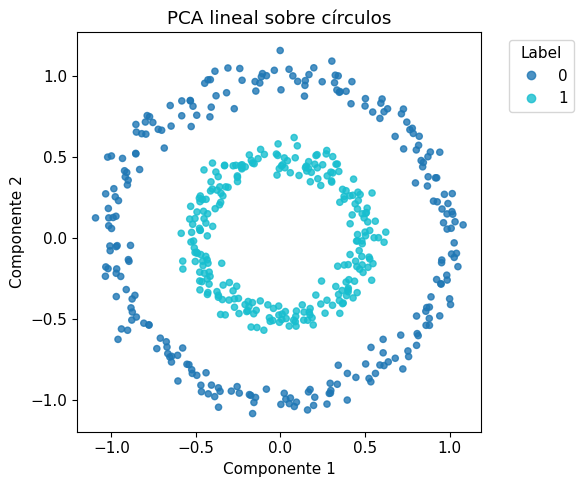

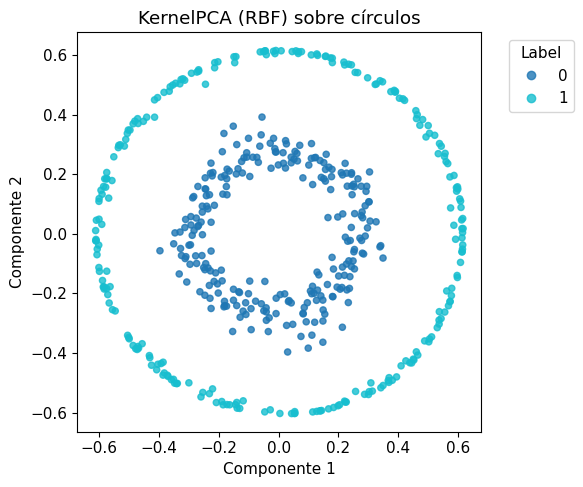

In [12]:
# PCA lineal sobre círculos (no separa bien)
pca_circles = PCA(n_components=2, random_state=RANDOM_STATE)
X_circles_pca = pca_circles.fit_transform(X_circles)
plot_2d_embedding(X_circles_pca, y_circles, title="PCA lineal sobre círculos")

# Kernel PCA con kernel RBF (no lineal)
kpca_rbf = KernelPCA(n_components=2, kernel="rbf", gamma=5, random_state=RANDOM_STATE)
X_circles_kpca = kpca_rbf.fit_transform(X_circles)
plot_2d_embedding(X_circles_kpca, y_circles, title="KernelPCA (RBF) sobre círculos")


## 2. Proyección lineal supervisada: LDA (Linear Discriminant Analysis)

A diferencia de PCA, que es **no supervisado**, LDA utiliza las etiquetas de clase para encontrar proyecciones que:

- Maximizan la separación entre clases.
- Minimicen la varianza dentro de cada clase.

Aplicaremos LDA sobre el dataset Iris y compararemos con PCA.


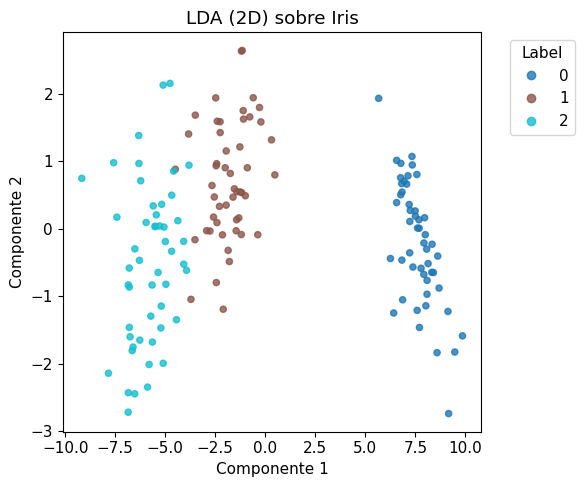

In [13]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_iris_lda = lda.fit_transform(X_iris_scaled, y_iris)

plot_2d_embedding(X_iris_lda, y_iris, title="LDA (2D) sobre Iris")


## 3. Métodos no lineales

En muchos casos, los datos viven sobre variedades (manifolds) no lineales embebidas en espacios de alta dimensión.  
Los métodos de **manifold learning** buscan recuperar una representación de baja dimensión preservando relaciones locales o geodésicas.

### 3.1 Isomap

Isomap aproxima distancias geodésicas en el grafo de vecinos cercanos y luego aplica MDS (esencialmente un PCA sobre la matriz de distancias).  
Es especialmente útil en ejemplos como el **swiss roll**.


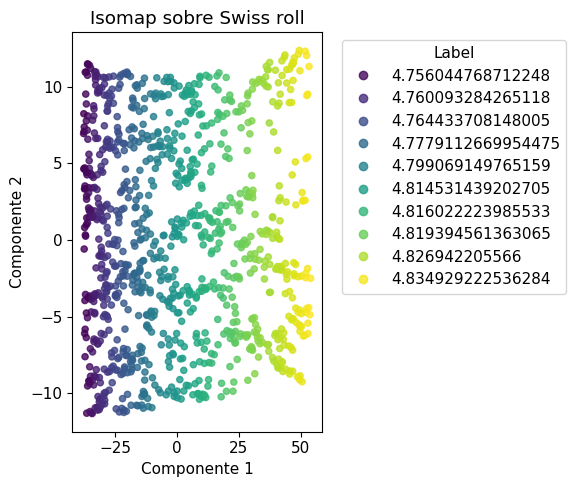

In [14]:
isomap = Isomap(n_neighbors=10, n_components=2)
X_swiss_isomap = isomap.fit_transform(X_swiss)

# Coloreamos por el parámetro t_swiss (posición en la "hoja")
plot_2d_embedding(X_swiss_isomap, t_swiss, title="Isomap sobre Swiss roll", cmap="viridis")


### 3.2 Locally Linear Embedding (LLE)

LLE intenta preservar relaciones lineales locales: cada punto se reconstruye como combinación lineal de sus vecinos, y esa estructura se mantiene en la proyección de baja dimensión.


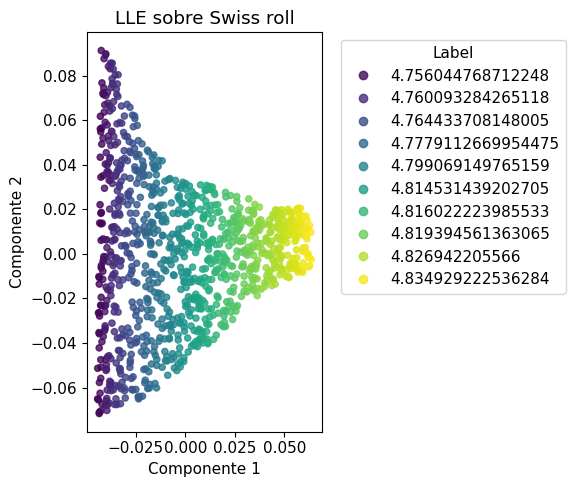

In [15]:
lle = LocallyLinearEmbedding(n_neighbors=10, n_components=2, method="standard", random_state=RANDOM_STATE)
X_swiss_lle = lle.fit_transform(X_swiss)

plot_2d_embedding(X_swiss_lle, t_swiss, title="LLE sobre Swiss roll", cmap="viridis")


## 4. t-SNE: Visualización de clusters en alta dimensión

t-SNE (t-distributed Stochastic Neighbor Embedding) es un método no lineal diseñado para **visualización** (generalmente 2D o 3D), que preserva relaciones de vecindad probabilísticas.

Lo aplicaremos al dataset `digits` (imágenes de dígitos escritos a mano).


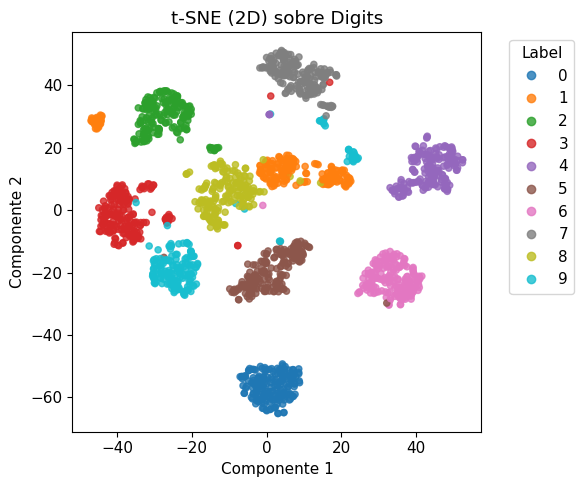

In [16]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=RANDOM_STATE)
X_digits_tsne = tsne.fit_transform(X_digits)

plot_2d_embedding(X_digits_tsne, y_digits, title="t-SNE (2D) sobre Digits", cmap="tab10")


## 5. UMAP (Uniform Manifold Approximation and Projection)

UMAP es un método no lineal que:

- Modela la estructura de los datos como un grafo fuzzy de alta dimensión.
- Optimiza una embeding de baja dimensión que preserva esa estructura.
- Suele ser más rápido que t-SNE y mantiene mejor la estructura global.

Aplicaremos UMAP sobre el mismo dataset `digits`.

> Nota: requiere `pip install umap-learn`.


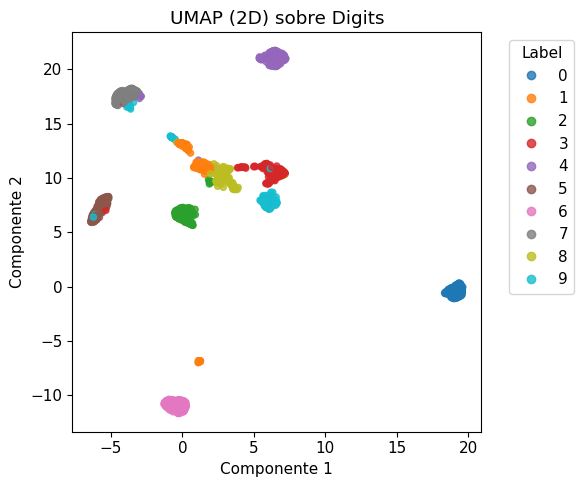

In [17]:
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=RANDOM_STATE)
X_digits_umap = reducer.fit_transform(X_digits)

plot_2d_embedding(X_digits_umap, y_digits, title="UMAP (2D) sobre Digits", cmap="tab10")


## 6. Comparación y recomendaciones prácticas

### Métodos lineales

- **PCA**:
  - Ventajas: simple, rápido, interpretable (combos lineales), útil como paso previo.
  - Limitaciones: solo captura estructuras lineales; puede no separar bien clases no linealmente separables.
- **IncrementalPCA**:
  - Útil para datasets grandes que no caben en memoria.
- **KernelPCA**:
  - Extiende PCA a relaciones no lineales usando kernels.
  - Costo computacional mayor; elección de kernel y parámetros (ej. `gamma`) no es trivial.
- **LDA**:
  - Supervisado; ideal para problemas de clasificación donde queremos maximizar separación entre clases.
  - Número máximo de componentes = número de clases - 1.

### Métodos no lineales

- **Isomap**:
  - Bueno para manifolds suaves tipo “swiss roll”.
  - Sensible a la elección del número de vecinos y a ruido fuerte.
- **LLE**:
  - Preserva relaciones lineales locales.
  - Puede ser inestable con ruido o mala elección de vecinos.
- **t-SNE**:
  - Excelente para visualización de clusters.
  - Costoso; no conserva bien estructura global; proyecciones no son fácilmente reutilizables.
- **UMAP**:
  - Rápido, buena preservación local y razonable preservación global.
  - Muy utilizado como “default” para visualización de embeddings (por ejemplo, embeddings de PLMs).

### Reglas heurísticas

- Si el objetivo es **preprocesar features** para un modelo → empezar con **PCA**.
- Si el objetivo es **visualización exploratoria de clusters** → probar **UMAP** y/o **t-SNE**.
- Si hay **etiquetas** y queremos separar clases linealmente → incluir **LDA**.
- Para datos sobre manifolds “suaves” conocidas → probar **Isomap** o **LLE**.
